# Test LambdaG Paraphrase Code

The notebook below is used to test the LambdaG paraphrase method across a subset of data.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from sentence_transformers import SentenceTransformer

/Users/user/Documents/GitHub/av_distributions/my_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sys.path.append(os.path.abspath('../src'))

from read_and_write_docs import read_jsonl, write_jsonl, read_rds
from utils import apply_temp_doc_id, build_metadata_df
from lambdaG import lambdaG, lambdaG_paraphrase, lambdaG_jsd, lambdaG_renyi, lambdaG_entropy_weighted, lambdaG_surprisal, lambdaG_hellinger
from performance import performance, performance_paraphrase

In [7]:
base_loc = "/Volumes/BCross/datasets/author_verification"

data_type = "training"
corpus = "Wiki"

model = "Qwen2.5-1.5B-Instruct"
model_name = model.lower().replace("-", "_")
token_type = model

known_loc = f"{base_loc}/sentence_log_probs_datasets/{data_type}/{corpus}/known_sentence_logprobs_{model_name}.jsonl"
# known_loc = "/Users/user/Documents/test_data/known_sentence_logprobs_qwen2.5_1.5b_instruct.jsonl"
known = read_jsonl(known_loc)
known.rename(columns={'sentence': 'text'}, inplace=True)
known = apply_temp_doc_id(known)
known = known[known['num_tokens'] > 0]
# known['perplexity'] = known['log_probs'].apply(compute_perplexity)

unknown_loc = f"{base_loc}/sentence_log_probs_datasets/{data_type}/{corpus}/unknown_sentence_logprobs_{model_name}.jsonl"
# unknown_loc = '/Users/user/Documents/test_data/unknown_sentence_logprobs_qwen2.5_1.5b_instruct.jsonl'
unknown = read_jsonl(unknown_loc)
unknown.rename(columns={'sentence': 'text'}, inplace=True)
unknown = apply_temp_doc_id(unknown)
unknown = unknown[unknown['num_tokens'] > 0]
# unknown['perplexity'] = unknown['log_probs'].apply(compute_perplexity)

metadata_loc = f"{base_loc}/{data_type}/metadata.rds"
metadata_loc = "/Users/user/Documents/test_data/metadata.rds"
metadata = read_rds(metadata_loc)
filtered_metadata = metadata[metadata['corpus'] == corpus]
agg_metadata = build_metadata_df(filtered_metadata, known, unknown)

# Set an impostor location
impostor_loc = "/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/top_impostors_tokenized"

In [8]:
known.head(2)

,doc_id,orig_doc_id,corpus,chunk_id,author,texttype,text,tokens,log_probs,med_log_prob,differences,abs_differences,num_tokens,sum_log_prob,avg_log_prob,mean_diff,mean_abs_diff
0,142_196_88_228_text_1,known [142.196.88.228 - Text-1].txt,Wiki,1,142.196.88.228,known,The article that is being referred to via the ...,"[The, article, that, is, being, referred, to, ...","[-16.99749755859375, -9.235851287841797, -4.50...","[-20.143911361694336, -20.143911361694336, -19...","[3.146413803100586, 10.908060073852539, 15.058...","[3.146413803100586, 10.908060073852539, 15.058...",51,-232.244278,-4.553809,16.524808,16.524808
1,142_196_88_228_text_1,known [142.196.88.228 - Text-1].txt,Wiki,2,142.196.88.228,known,"This study provides little to nothing, which j...","[This, study, provides, little, to, nothing, ,...","[-14.410652160644531, -6.185196876525879, -3.5...","[-20.189170837402344, -20.189170837402344, -20...","[5.7785186767578125, 14.003973960876465, 17.35...","[5.7785186767578125, 14.003973960876465, 17.35...",21,-99.708021,-4.748001,15.963466,15.963466


In [9]:
known_filtered = known[known['author'].isin(['Akuri', '142.196.88.228'])]

In [13]:
data_orig = lambdaG(unknown, known_filtered, known, metadata=agg_metadata)
data_orig

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,23649.727511
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,-8920.740032
2,Akuri vs Akuri,Akuri,Akuri,True,18284.714174
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,-3933.146344


In [14]:
data_para = lambdaG_paraphrase(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_para

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,60700.090541
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,38867.111745
2,Akuri vs Akuri,Akuri,Akuri,True,103694.410850
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,41226.079205


In [15]:
data_jsd = lambdaG_jsd(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_jsd

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,0.279059
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,0.156291
2,Akuri vs Akuri,Akuri,Akuri,True,0.353886
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,0.201403


In [6]:
data_renyi = lambdaG_renyi(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_renyi

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,1.895182
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,1.310015
2,Akuri vs Akuri,Akuri,Akuri,True,2.261512
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,1.502777


In [10]:
data_ent = lambdaG_entropy_weighted(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_ent

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,63958.103249
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,39072.679453
2,Akuri vs Akuri,Akuri,Akuri,True,102930.553644
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,42500.666591


In [11]:
data_surp = lambdaG_surprisal(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_surp

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,0.543132
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,0.367391
2,Akuri vs Akuri,Akuri,Akuri,True,0.669852
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,0.501564


In [12]:
data_hell = lambdaG_hellinger(unknown, known_filtered, metadata=agg_metadata, impostor_loc=impostor_loc)
data_hell

    There are 2 known author(s) and 4 problem(s) in the dataset.
        Working on problem 1 of 4: 142.196.88.228 vs 142.196.88.228
        Working on problem 2 of 4: 142.196.88.228 vs Aban1313
        Working on problem 3 of 4: Akuri vs Akuri
        Working on problem 4 of 4: Akuri vs AlanBarnet


,problem,known_author,unknown_author,target,score
0,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,0.187988
1,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,0.103720
2,Akuri vs Akuri,Akuri,Akuri,True,0.248138
3,Akuri vs AlanBarnet,Akuri,AlanBarnet,False,0.136328


In [13]:
# all_results = []

# for rep in range(1, 4): 
#     print(f"Repetition {rep}")
#     df = lambdaG_renyi(unknown, known, metadata=agg_metadata, impostor_loc=impostor_loc)

#     # Add the repetition column at the start:
#     df.insert(0, 'repetition', rep)
#     df.insert(1, 'corpus', corpus)      # move corpus next
#     df.insert(2, 'data_type', data_type)
#     df.insert(2, 'token_type', token_type) 
#     all_results.append(df)

# # Combine all repetitions into one DataFrame
# test_res_long = pd.concat(all_results, ignore_index=True)

In [7]:
test_df = read_jsonl('/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/lambda_g_results.jsonl')

In [8]:
test_df.head(5)

,repetition,corpus,data_type,token_type,description,problem,known_author,unknown_author,target,score
0,1,Wiki,training,Qwen2.5-1.5B-Instruct,Gen - Temp - 1.5 - Qwen 2.5 1.5B,142.196.88.228 vs 142.196.88.228,142.196.88.228,142.196.88.228,True,61391.791086
1,1,Wiki,training,Qwen2.5-1.5B-Instruct,Gen - Temp - 1.5 - Qwen 2.5 1.5B,142.196.88.228 vs Aban1313,142.196.88.228,Aban1313,False,38604.341712
2,1,Wiki,training,Qwen2.5-1.5B-Instruct,Gen - Temp - 1.5 - Qwen 2.5 1.5B,A_Man_In_Black vs A_Man_In_Black,A_Man_In_Black,A_Man_In_Black,True,61655.847654
3,1,Wiki,training,Qwen2.5-1.5B-Instruct,Gen - Temp - 1.5 - Qwen 2.5 1.5B,A_Man_In_Black vs Bankhallbretherton,A_Man_In_Black,Bankhallbretherton,False,32560.018139
4,1,Wiki,training,Qwen2.5-1.5B-Instruct,Gen - Temp - 1.5 - Qwen 2.5 1.5B,Aban1313 vs Aban1313,Aban1313,Aban1313,True,55211.503158


In [18]:
results_agg = (
    data_hell
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)
score_col = 'score'
target_col = 'target'
performance_paraphrase(results_agg,
            score_col,
            target_col,
            additional_metadata={
                'corpus': corpus
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki,0.359241,0.237066,0.0,6.251753,-4.752175,2,2,1.0,0.75,1.0,0.5,0.666667,1,0,1,2


In [16]:
results_agg = (
    data_hell
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)
score_col = 'score'
target_col = 'target'
performance(results_agg,
            score_col,
            target_col,
            additional_metadata={
                'corpus': corpus
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki,1.581383,1.581383,1.0,-0.299544,0.299281,2,2,0.0,0.0,0.0,0.0,0.0,0,2,2,0


In [10]:
data = read_jsonl('/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/lambda_g_results.jsonl')

In [19]:
grouped_data = (
    data
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)

In [20]:
grouped_data

,problem,target,score
0,142.196.88.228 vs 142.196.88.228,True,56394.564217
1,142.196.88.228 vs Aban1313,False,33592.264230
2,Akuri vs Akuri,True,70249.047340
3,Akuri vs AlanBarnet,False,21594.775806


In [21]:
import matplotlib.pyplot as plt

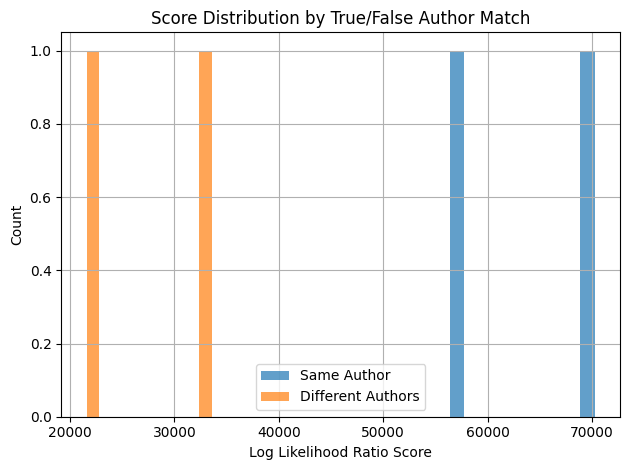

In [22]:
# Plot histogram of scores by target
plt.figure()
grouped_data[grouped_data['target'] == True]['score'].hist(alpha=0.7, label='Same Author')
grouped_data[grouped_data['target'] == False]['score'].hist(alpha=0.7, label='Different Authors')
plt.title('Score Distribution by True/False Author Match')
plt.xlabel('Log Likelihood Ratio Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

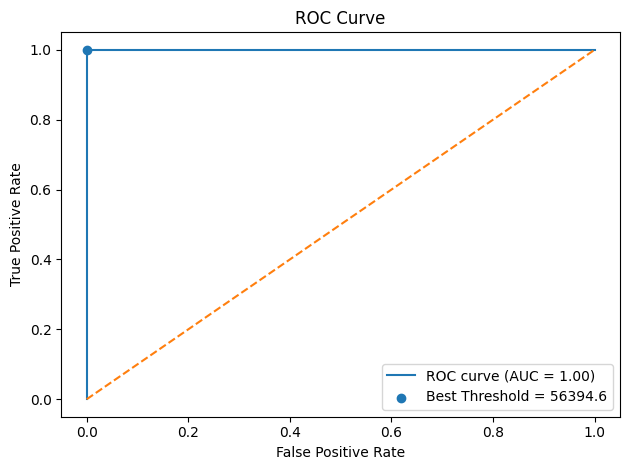

In [23]:
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, accuracy_score
import pandas as pd

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(grouped_data['target'], grouped_data['score'])
roc_auc = auc(fpr, tpr)

# Determine best threshold (Youden's J statistic)
youden_j = tpr - fpr
best_idx = youden_j.argmax()
best_threshold = thresholds[best_idx]

# Compute metrics at best threshold
preds = grouped_data['score'] >= best_threshold
f1 = f1_score(grouped_data['target'], preds)
accuracy = accuracy_score(grouped_data['target'], preds)
cm = confusion_matrix(grouped_data['target'], preds)
cm_df = pd.DataFrame(cm, index=['Actual False', 'Actual True'], columns=['Predicted False', 'Predicted True'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', label=f'Best Threshold = {best_threshold:.1f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Display metrics and confusion matrix
print(f"Optimal Threshold (Youden's J): {best_threshold:.3f}")
print(f"AUC: {roc_auc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Optimal Threshold (Youden's J): 56394.564
AUC: 1.000
F1 Score: 1.000
Accuracy: 1.000


In [27]:
cm_df

,Predicted False,Predicted True
Actual False,2,0
Actual True,0,2
